In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from store import *
import kbech32

In [2]:
store = Store(os.getenv('localappdata') + r'\Kaspad\kaspa-mainnet\datadir2')
store.load_blocks()

Pruning point:  96aeb403d5ddb7fa07e7578e218cdd4614126f620a6a432d981054be512c32d5
Loaded 40000 blocks
Loaded 80000 blocks
Loaded 120000 blocks
Loaded 160000 blocks
Loaded 200000 blocks
Loaded 240000 blocks
Loaded 280000 blocks
Overall number of headers:  318571


In [3]:
header_fields = ['timeInMilliseconds', 'blueScore', 'blueWork', 'daaScore', 'difficulty']
block_fields = ['pubkey_script']
count_fields = ['num_parents', 'num_children', 'num_blues', 'num_reds']
frames = store.load_data(header_fields=header_fields, block_fields=block_fields, count_fields=count_fields)

  0%|          | 0/318571 [00:00<?, ?it/s]

Number of headers missing header data:  1
Number of blocks missing block data:  1


In [4]:
frames.keys()

dict_keys(['hash', 'timeInMilliseconds', 'blueScore', 'blueWork', 'daaScore', 'difficulty', 'pubkey_script', 'num_parents', 'num_children', 'num_blues', 'num_reds'])

In [5]:
df = pd.DataFrame(frames).set_index('hash')

In [6]:
pp_time = store.get_header_data(store.pruning_point()).timeInMilliseconds
pp_time

1646073866929

## Number of child blocks

This is the first sign somthing is wrong -- A high number of child blocks indicates that some miners are stuck mining on some point in history, and are not even succeding to update their node about the blocks they have found. 

In the figure below we see that at some point last night many blocks were mined over the same points in DAG history (up to 200 blocks over each point).  

This event seems to take place over ~5 hours (It is also possible that the miner is stuck with old timestamps, but is actually mining these blocks since that point until now)  

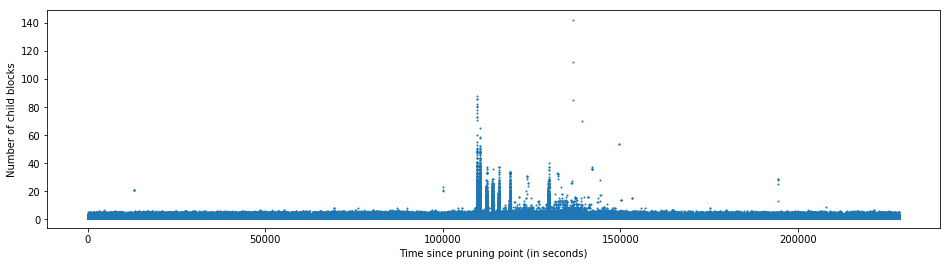

In [7]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_children'], s=1)
plt.ylabel('Number of child blocks')
plt.xlabel('Time since pruning point (in seconds)')
plt.show()

## Number of merged reds 

Here we already see an indication of a netsplit. Not only that (or those) miner is stuck, but it also did not publish his blocks for a few hours. It seems like all or most of these blocks were published over the following 5 hours. 

Since the network merges them as red blocks in bulks of max 180, we see this in the following figure.

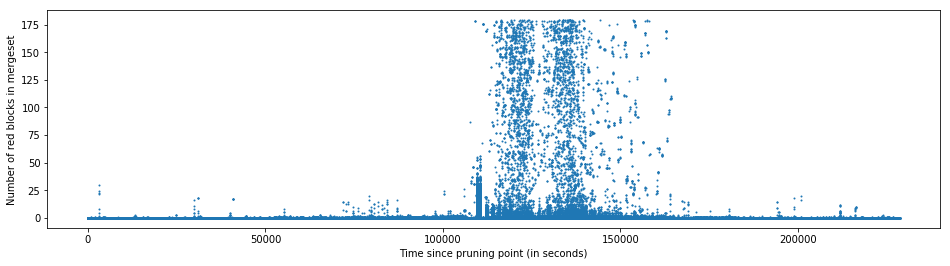

In [8]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_reds'], s=1)
plt.ylabel('Number of red blocks in mergeset')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\reds.png')
plt.show()

## Global hashrate waves

It seems like the above huge merge events envolved performance issues in all nodes in the network (many blocks published at once with weird DAG structure which challenges current kaspa imp) -- this in turn leads to the node being unsynced for short periods -- which reduces the hashrate of each node -- hence leading to a global effect.  

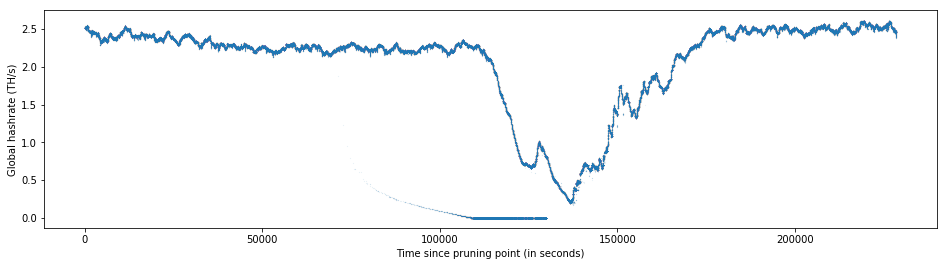

In [9]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['difficulty']*2/1000000000000, s=0.001)
plt.ylabel('Global hashrate (TH/s)')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\ghr.png')
plt.show()

## Blue work

This indicates that the side-DAG was not accumulating its work in a proper *k*-cluster (`k=18` in our system), but rather creating "antichains" (note the flat lines below)

This indicates this was probably not a deliberate attack, or if it was, it was attacking performance but not attaempting a reorg. 

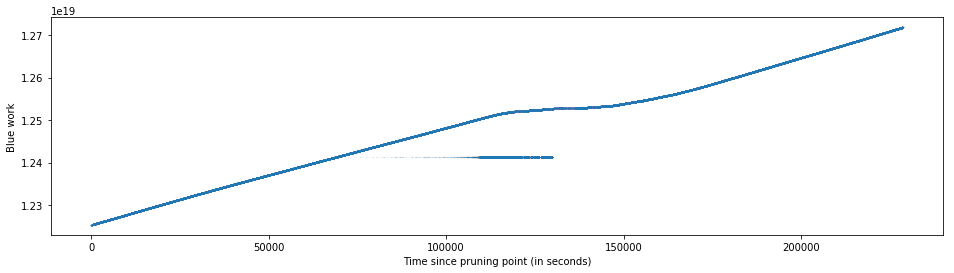

In [10]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueWork'], s=0.0005)
plt.ylabel('Blue work')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\bw.png')
plt.show()

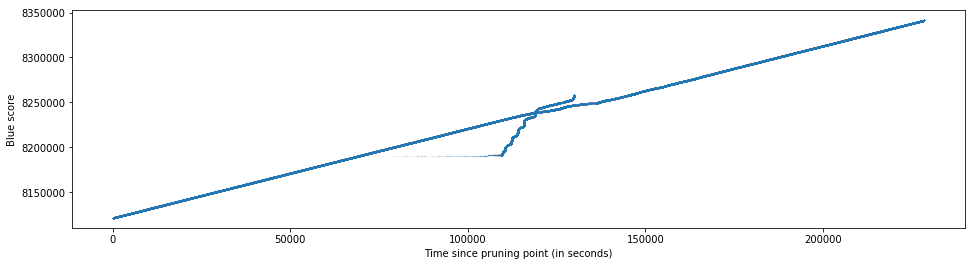

In [11]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueScore'], s=0.0005)
plt.ylabel('Blue score')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\bw.png')
plt.show()

In [12]:
df_sortedby_time = df.sort_values(by='timeInMilliseconds')

## Block count

During this event, however, both disonnected parts mine at a rate of 1 block per second, so block rate was doubled for a few hours as seen below.

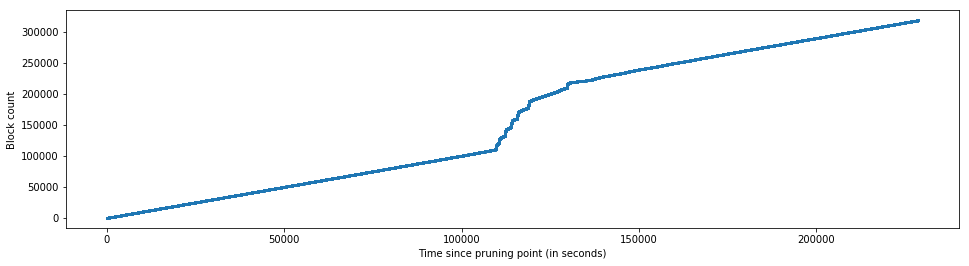

In [13]:
plt.figure(figsize=(16, 4))
plt.scatter((df_sortedby_time['timeInMilliseconds'] - pp_time)/1000, np.arange(len(df_sortedby_time['daaScore'])), s=1)
plt.ylabel('Block count')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\count.png')
plt.show()

## DAA score

Despite the double amount of blocks (which does effect processing time), DAA score which controls the emission rate of KAS, was uneffected since by design it considres rewards only from one side of the split.

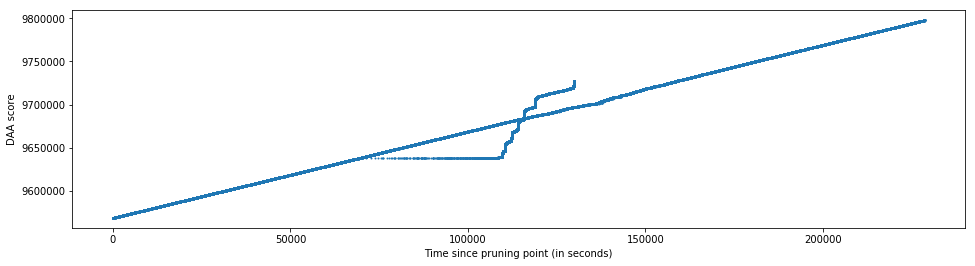

In [14]:
plt.figure(figsize=(16, 4))
plt.scatter((df_sortedby_time['timeInMilliseconds'] - pp_time)/1000, df_sortedby_time['daaScore'], s=1)
plt.ylabel('DAA score')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\daa.png')
plt.show()

In [20]:
df_groupedby_miner = df.groupby('pubkey_script')

In [21]:
len(df_groupedby_miner)

371

## Explore mining addresses of red blocks

Below we explore the mining addresses of those stalled red blocks and observe they mostly come from ~8 mining addresses.

In [22]:
virtual_reds = store.get_virtual_reds(threshold=0, time_distance=3600*1000)
len(virtual_reds)

87761

In [23]:
miner_scripts = {}
for r in virtual_reds:
    if r in df.index:
        key = df.loc[r]['pubkey_script']
        if key in miner_scripts:
            miner_scripts[key] += 1
        else:
            miner_scripts[key] = 1
len(miner_scripts)

18

In [24]:
miners_sortedby_reds = sorted(miner_scripts.items(), key=lambda kvp: kvp[1], reverse=True)

**Miner addresses with large amounts of red blocks:**

In [28]:
for kvp in miners_sortedby_reds:
    if kvp[1] < 500:
        break
    print(kbech32.toAddress(kvp[0]), '\t', kvp[1])

kaspa:qpg4an3eglng83cr2pks5ghd3hxgfldf5fcasfgq22lq7a6mvz4659jmj94xc 	 81025
kaspa:pzhh76qc82wzduvsrd9xh4zde9qhp0xc8rl7qu2mvl2e42uvdqt75zrcgpm00 	 6709


In [26]:
# store.close()